# Using the model's output [probability] to determine the most thrombolysable patient per hospital

In notebook "20_synthetic_patients.ipynb" we explore creating synthetic patients - those that have features that are favourable to use of thrombolysis.

In notebook "21_very_thrombolysable_patient criteria.ipynb" we find that in our dataset (of the patients that attend hospitals) that the criteria used to define a thrombolysable patient means not all hospitals have an example of these patients attending them.

Task 1. 

Here we look to see what the most thrombolysable patient that attends each hosptial looks like, taking the "most thrombolysable" as the patient with the highest probability value from the model output (from the test set - using 5-kfold).

Four of the feature values strongly agree across the 132 most thrombolysable patients (one per hospital): 
1) Prior disability is either mnRS 0 or 1 (full range is up to mRS 5)
2) Infarction (not haemorrhage)
3) No use of AF anticoagulants
4) Precise onset time known.

We see that there are three features that have some range in their values for the 132 most thrombolysable patients (one per hospital):
1) Arrival-to-scan ranges from 0-50 minutes (median ~10 minutes)
2) stroke severity ranges from 6-36 NIHSS (median ~17 NIHSS)
3) Onset-to-arrival time ranges from 0-200 minutes (median ~60 minutes)

Task 2. 

Once identifying the most thrombolysable patient for each individual hospital (taking the "most thrombolysable" as the patient with the highest probability value from the model output), we see that 17 of these patients did not receive thrombolysis from the hospital they attended. 

For each of these 17 hospitals, plot a violin plot show the range of feature values for the two populations: 1) patients they thrombolysed, and 2) patients that they did not thrombolyse. Compare with the feature values of the "most thombolysable" patient that did not recieve thrombolysis.



Import libraries

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [2]:
with open("./output/feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

In [3]:
data_loc = '../data/kfold_5fold/'

In [4]:
# Initialise empty lists
test_data = []

# Read in the names of the selected features for the model
number_of_features_to_use = 8
key_features = pd.read_csv('./output/feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append("S2Thrombolysis")

for i in range(5):
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=feature_name_dict, inplace=True)
    test_data.append(test)

In [5]:
data = pd.concat(test_data, ignore_index=True)

## Load model output predictions

In [6]:
model_type = 'xgb_combined_key_features'

In [7]:
#model_predictions = pd.DataFrame()
#model_predictions['hospital'] = hospital_results
#model_predictions['observed'] = np.array(observed_results) * 1.0
#model_predictions['prob'] = prob_results
#model_predictions['predicted'] = predicted_results
#model_predictions['k_fold'] = kfold_result
#model_predictions['correct'] = model_predictions['observed'] == model_predictions['predicted']

# Save
filename = f'./predictions/{model_type}_predictions.csv'
model_predictions = pd.read_csv(filename)

In [8]:
model_predictions

,hospital,observed,prob,predicted,k_fold,correct
0,TXHRP7672C,1.0,0.880155,1.0,0,True
1,SQGXB9559U,1.0,0.627783,1.0,0,True
2,LFPMM4706C,0.0,0.042199,0.0,0,True
3,MHMYL4920B,0.0,0.000084,0.0,0,True
4,EQZZZ5658G,1.0,0.916311,1.0,0,True
...,...,...,...,...,...,...
88787,OYASQ1316D,1.0,0.917107,1.0,4,True
88788,SMVTP6284P,0.0,0.023144,0.0,4,True
88789,RDVPJ0375X,0.0,0.089444,0.0,4,True
88790,FAJKD7118X,0.0,0.615767,1.0,4,False


The two datasets (the model prediction, and the combined five test sets) are in the same patient order. But let's check this by showing that the order of the stroke team (a common column) is aligned between these two datasets.

In [9]:
# Store True/False for a match
match = model_predictions["hospital"] == data["Stroke team"]
# If sum equals count, then the Stroke Team order matches
match.sum() == match.count()

True

## Find "most thromoblysable" patient per hosptial (highest probability)

Create dataframe containing the feature data for the 132 patients, each one is the most thrombolysable for the hosptial they attend (based ont eh model output probabililty)

In [10]:
# per hospital, get index of patient with highest probability
index_top_IVT_patient_cohort = (
                    model_predictions.groupby(["hospital"])["prob"].idxmax())

# And store the highest probability value
prob_top_IVT_patient_cohort = (
                    model_predictions.groupby(["hospital"])["prob"].max())
# extract the "most thrombolysable" patient per hospital
data_top_IVT_patient_cohort = data.iloc[index_top_IVT_patient_cohort]

# Add column containing the probability model output value
data_top_IVT_patient_cohort["prob"] = prob_top_IVT_patient_cohort.values

data_top_IVT_patient_cohort.head()

/tmp/ipykernel_79261/2523740092.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_top_IVT_patient_cohort["prob"] = prob_top_IVT_patient_cohort.values


,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulents,Onset-to-arrival time,Thrombolysis,prob
84341,18.0,1,11.0,1,0,AGNOF1041H,0,94.0,1,0.956823
15140,7.0,1,22.0,1,0,AKCGO9726K,0,55.0,0,0.965631
220,1.0,1,18.0,1,0,AOBTM3098N,0,81.0,0,0.916160
54026,15.0,1,25.0,1,0,APXEE8191H,0,53.0,1,0.959907
57062,16.0,1,13.0,1,0,ATDID5461S,0,35.0,1,0.926625


In [11]:
data_top_IVT_patient_cohort["prob"].mean()

0.9537807590909092

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f0ad9b5d100>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f0ad9b42f10>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f0ad9b5d5e0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f0ad9b5d910>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7f0ad9b5dc40>}

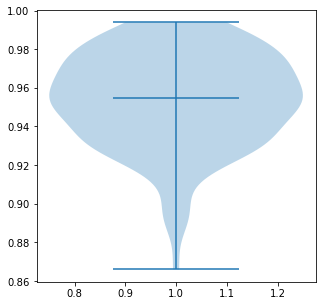

In [12]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.violinplot(data_top_IVT_patient_cohort["prob"], showmedians=True)#, widths=width, )


Show the range of each feature value for these 132 patients

Feature distributions for the most thrombolysable patient per hospital (132 patients)



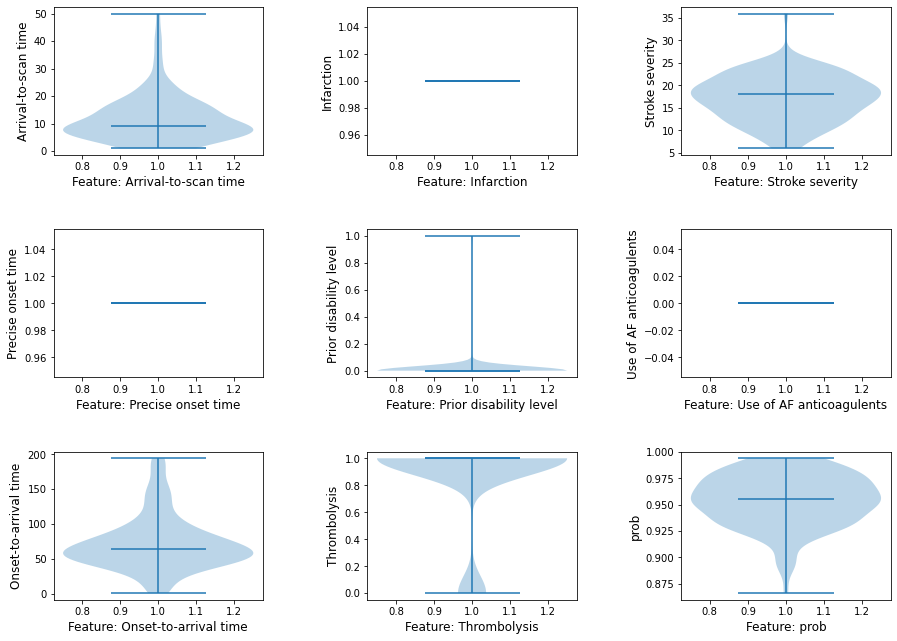

In [13]:
columns = ["Arrival-to-scan time", "Infarction", "Stroke severity",
           "Precise onset time", "Prior disability level",
           "Use of AF anticoagulents", "Onset-to-arrival time", "Thrombolysis",
           "prob"]

print ("Feature distributions for the most thrombolysable patient per "
       "hospital (132 patients)")
print()
fig = plt.figure(figsize=(15,15))

ncols = 3
nrows = int((len(columns)/ncols)+1)
counter = 0
for col in columns:
    counter += 1
    # create violin plot
    ax = fig.add_subplot(nrows, ncols, counter)
    ax.violinplot(data_top_IVT_patient_cohort[col], 
                  showmedians=True)#, widths=width, )

    # customise the axes
#    ax.set_title(f'Feature distribution for the \nmost thrombolysable patient per hospital')
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylabel(f'{col}', fontsize=12)
    ax.set_xlabel(f'Feature: {col}', fontsize=12)

    plt.subplots_adjust(hspace=0.5, wspace=0.5)

See some of these patients did not receive thrombolysis from their attended hosptial in real life.

Get all hosptials that don't thrombolyse their most thrombolysable patient (in terms of model probability)

In [14]:
mask = data_top_IVT_patient_cohort["Thrombolysis"] == 0
stroke_team_not_thrombolyse_most_suitable = (
                            data_top_IVT_patient_cohort["Stroke team"][mask])

n = stroke_team_not_thrombolyse_most_suitable.shape[0]

print (f"There are {n} hospitals that do not give thrombolysis to the patient "
       f"that the model classes as the most thrombolysable patient that attends"
       f" their hospital")

There are 17 hospitals that do not give thrombolysis to the patient that the model classes as the most thrombolysable patient that attends their hospital


For each hospital that does not thrombolyse their most thrombolysable patient, compare the feature value of their most thrombolysable patient with the range of feature values for 1) the population of patients that the hospital thrombolyses, and 2) not.

In the charts below (one set of plots per hospital), show the two populations as violin plots, and the most thrombolysable patient as red line.

Feature distributions for thrombolysed and not thrombolysed patients attending hospital AKCGO9726K

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



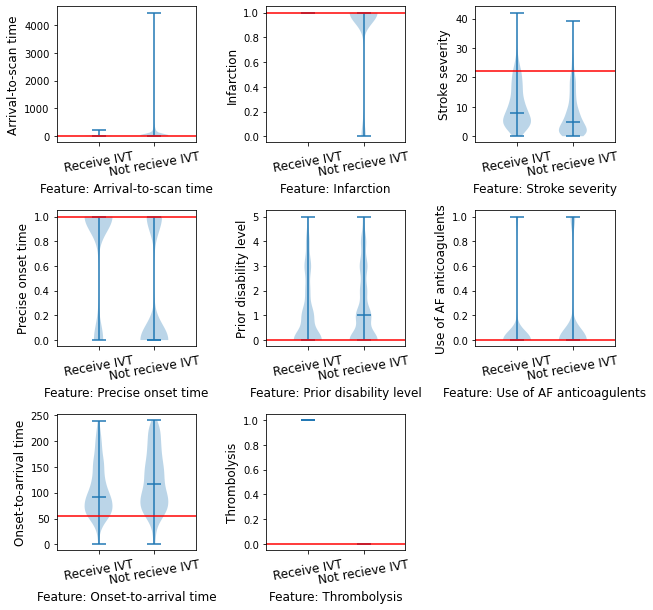


Feature distributions for thrombolysed and not thrombolysed patients attending hospital AOBTM3098N

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



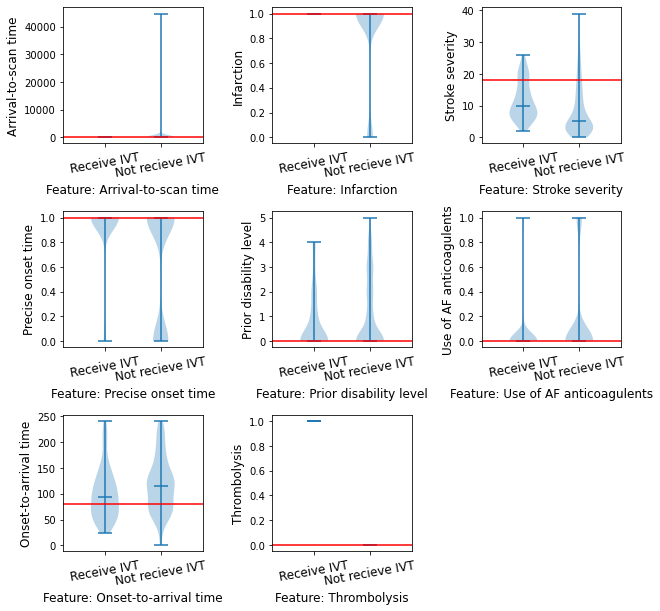


Feature distributions for thrombolysed and not thrombolysed patients attending hospital BICAW1125K

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



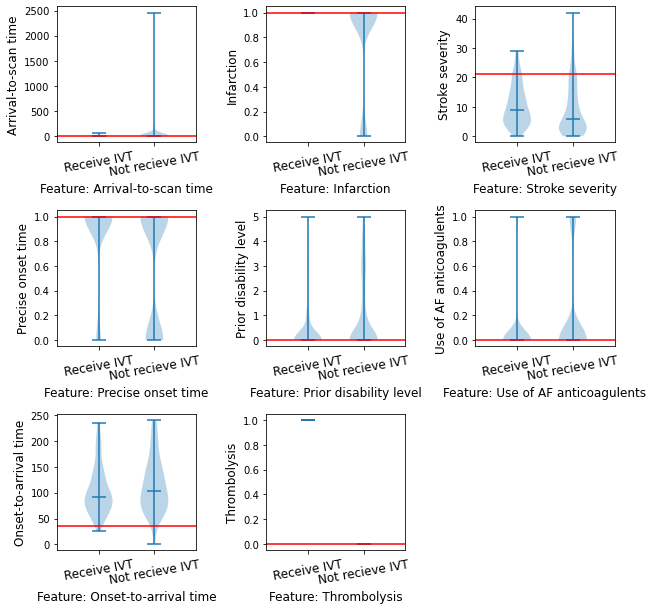


Feature distributions for thrombolysed and not thrombolysed patients attending hospital DANAH4615Q

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



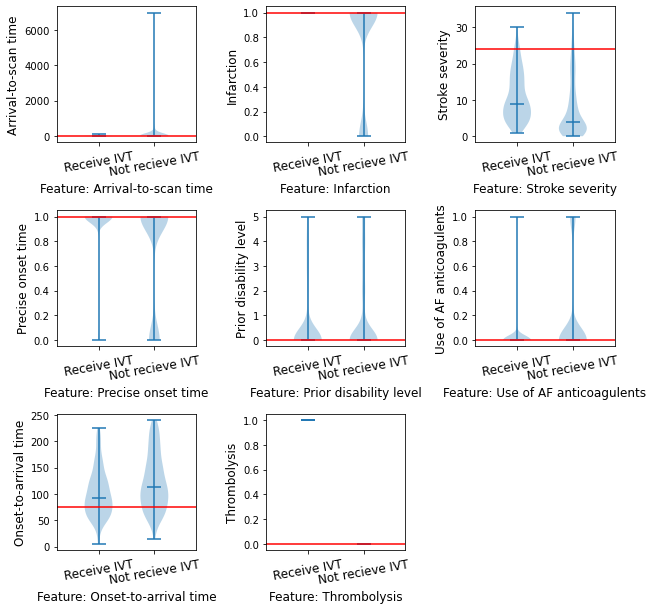


Feature distributions for thrombolysed and not thrombolysed patients attending hospital DZJVD1372Z

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



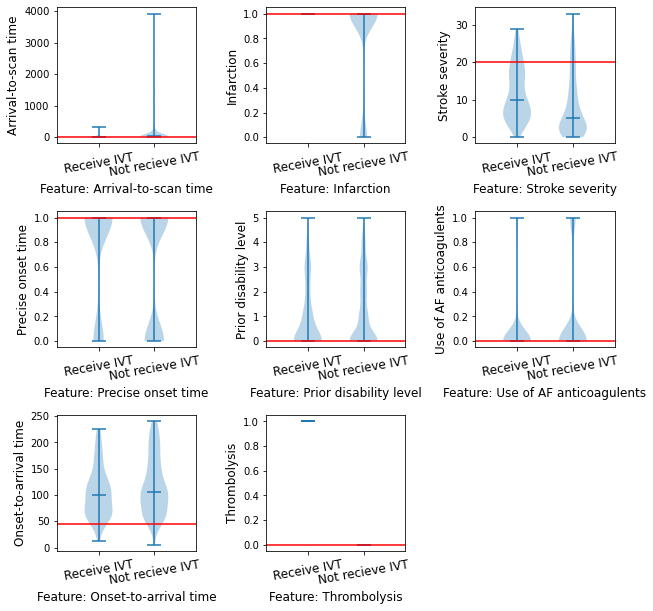


Feature distributions for thrombolysed and not thrombolysed patients attending hospital HZMLX7970T

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



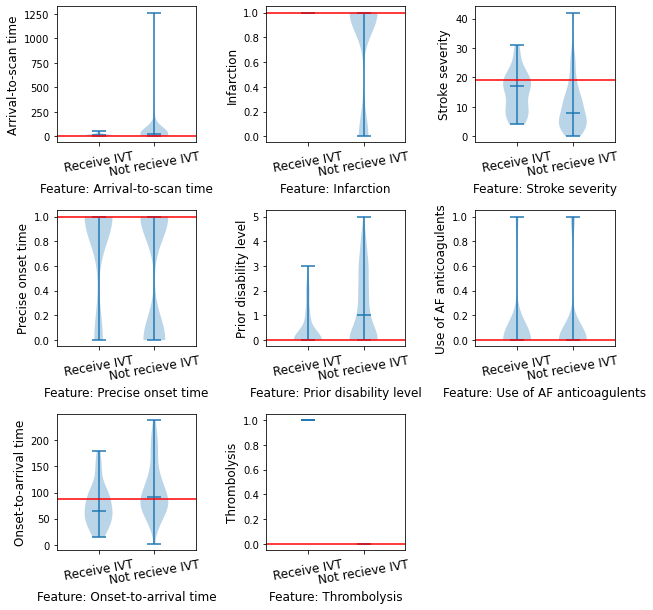


Feature distributions for thrombolysed and not thrombolysed patients attending hospital IYJHY1440E

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



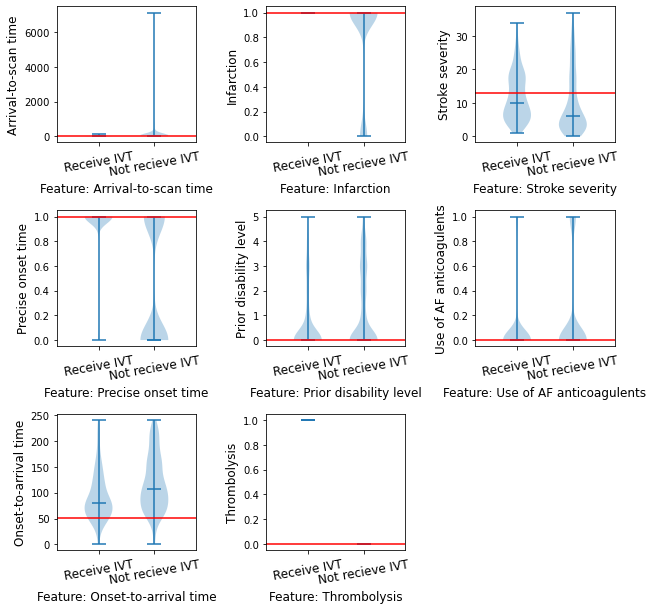


Feature distributions for thrombolysed and not thrombolysed patients attending hospital JINXD0311F

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



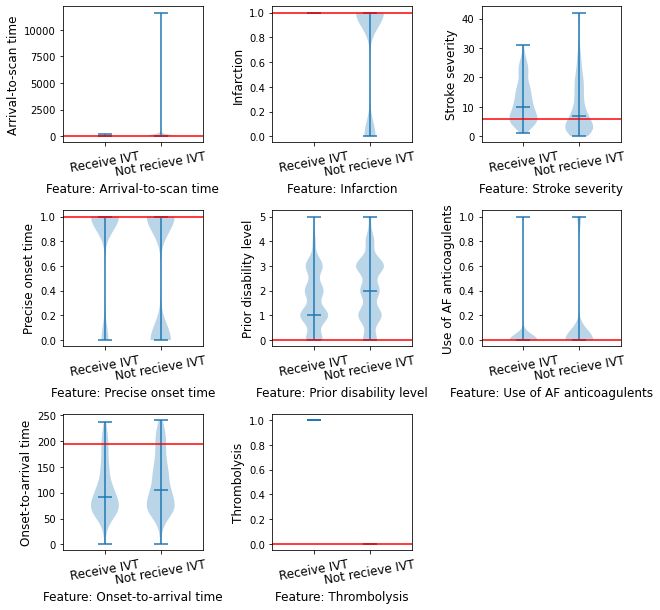


Feature distributions for thrombolysed and not thrombolysed patients attending hospital JXJYG0100P

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



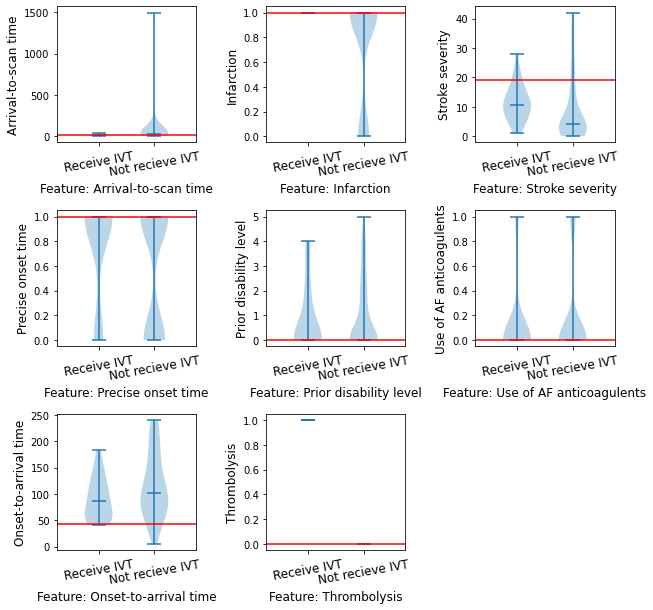


Feature distributions for thrombolysed and not thrombolysed patients attending hospital KZKEZ2257Z

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



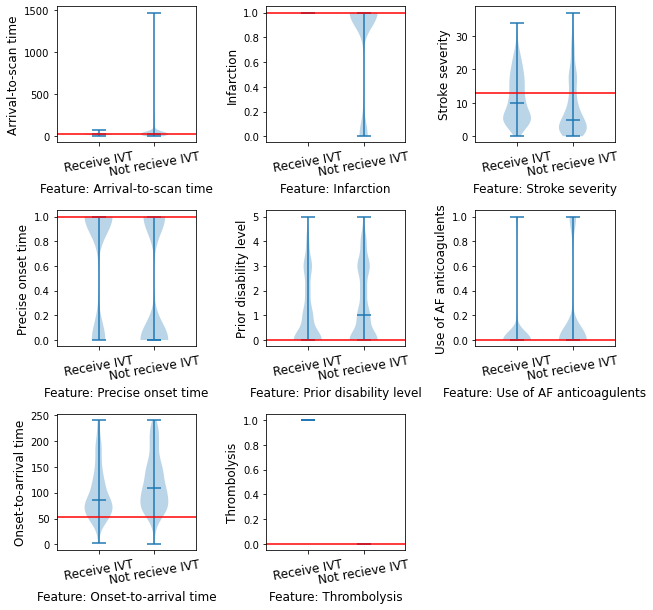


Feature distributions for thrombolysed and not thrombolysed patients attending hospital LFPMM4706C

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



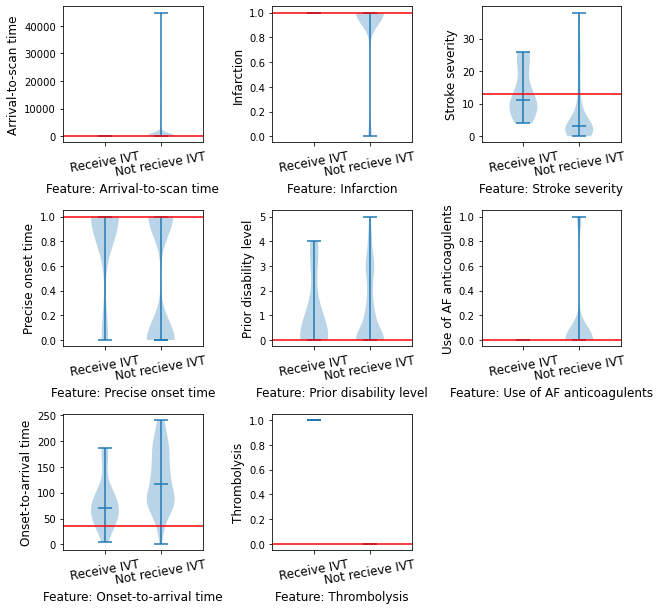


Feature distributions for thrombolysed and not thrombolysed patients attending hospital QWKRA8499D

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



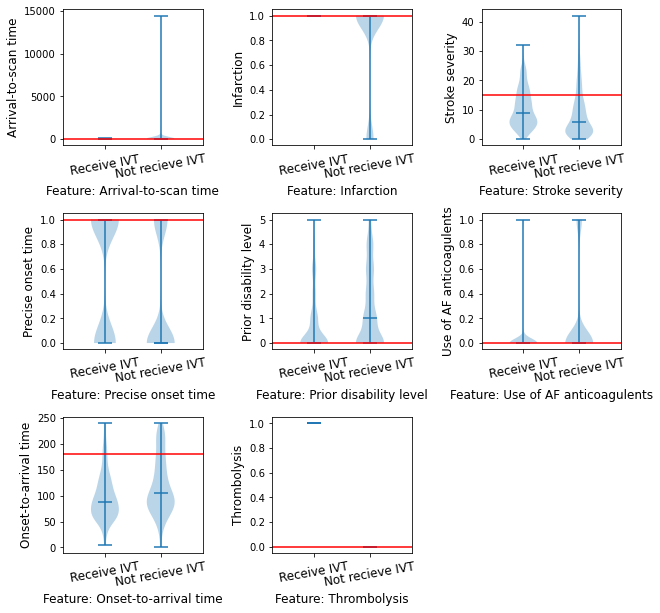


Feature distributions for thrombolysed and not thrombolysed patients attending hospital RDVPJ0375X

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



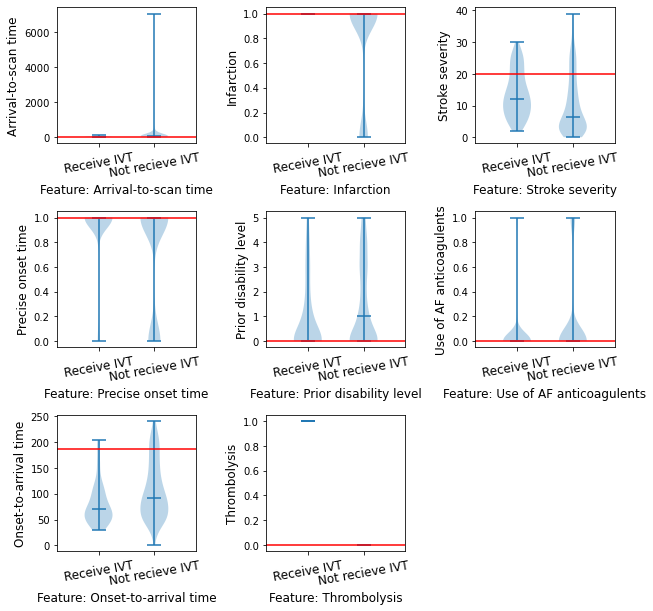


Feature distributions for thrombolysed and not thrombolysed patients attending hospital SJVFI6669M

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



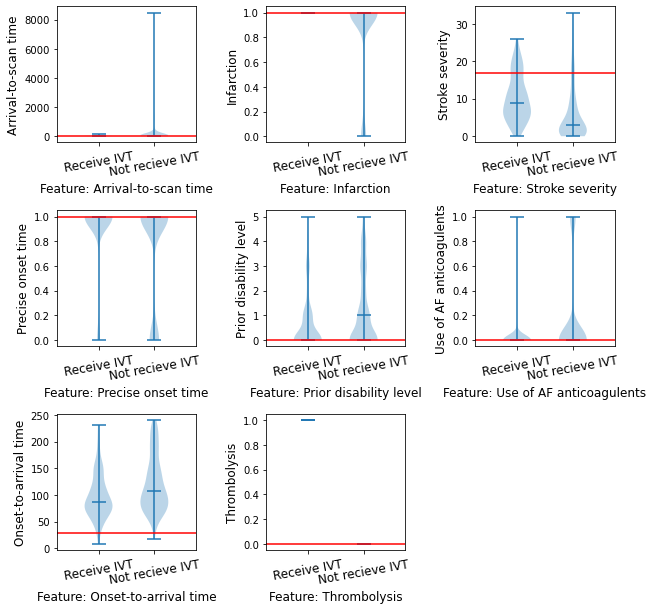


Feature distributions for thrombolysed and not thrombolysed patients attending hospital SMVTP6284P

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



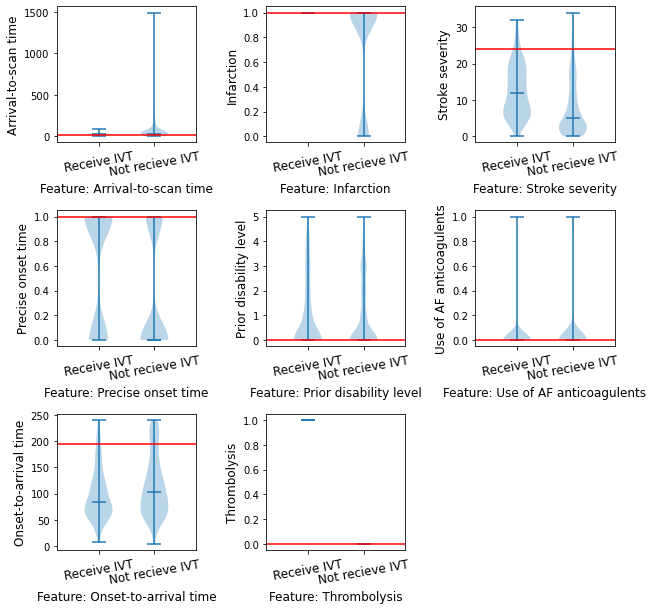


Feature distributions for thrombolysed and not thrombolysed patients attending hospital VKHPY9501A

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



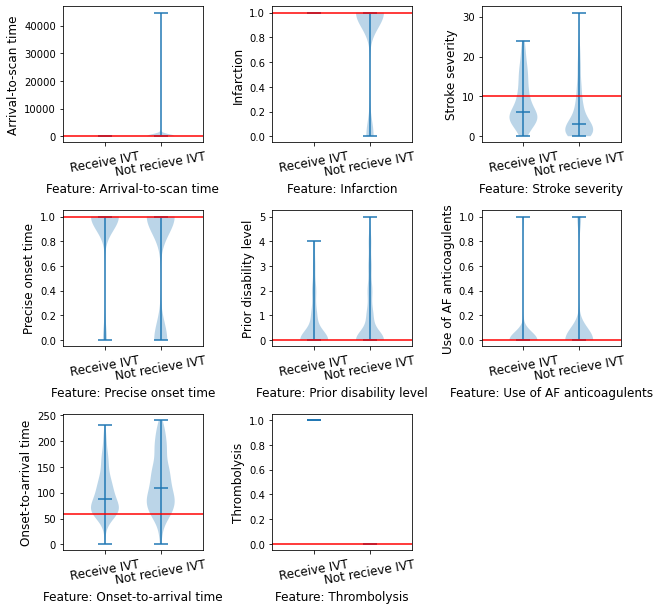


Feature distributions for thrombolysed and not thrombolysed patients attending hospital ZBVSO0975W

Red line shows the feature value for the patient most suitable to thrombolysis, according to model output [probability], but in real world this patient didn't receive thrombolysis



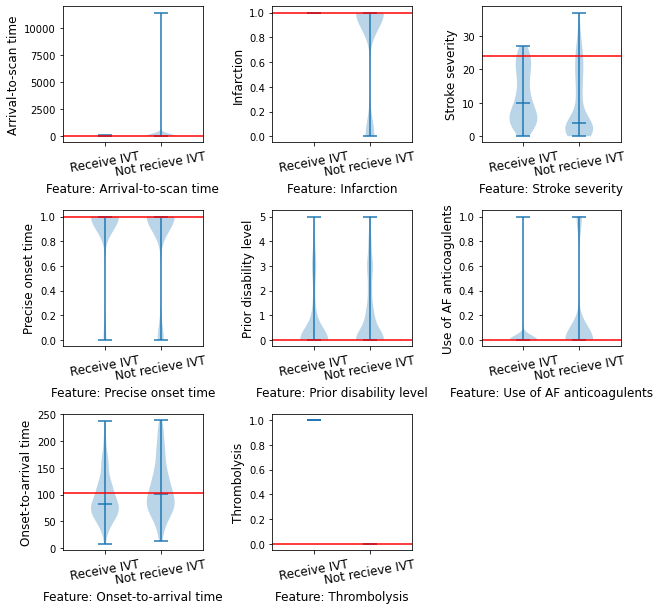

In [15]:
# Define columns to show violin plot for
columns = ["Arrival-to-scan time", "Infarction", "Stroke severity",
           "Precise onset time", "Prior disability level",
           "Use of AF anticoagulents", "Onset-to-arrival time", "Thrombolysis"]

for stroke_team in stroke_team_not_thrombolyse_most_suitable:

    # Get rows from dataframe for this stroke team
    mask = data["Stroke team"] == stroke_team
    data_stroke_team = data[mask] 

    # Split patiens into two populations. 1) not receive thrombolysis
    mask = data_stroke_team["Thrombolysis"] == 0
    data_stroke_team_not_ivt = data_stroke_team[mask]
    # 2) receive thrombolysis
    mask = np.logical_not(mask)
    data_stroke_team_ivt = data_stroke_team[mask]
    
    print (f"Feature distributions for thrombolysed and not thrombolysed patients "
           f"attending hospital {stroke_team}")
    print()
    print("Red line shows the feature value for the patient most suitable to "
          "thrombolysis, according to model output [probability], but in real "
          "world this patient didn't receive thrombolysis")
    print()
    
    fig = plt.figure(figsize=(10,10))

    n_categories = 2 # thrombolyse, and not

    ncols = 3
    nrows = int((len(columns)/ncols)+1)
    counter = 0
    for col in columns:
        counter += 1
        # create violin plot
        ax = fig.add_subplot(nrows, ncols, counter)
        ax.violinplot([data_stroke_team_ivt [col],
                       data_stroke_team_not_ivt[col]],
                      showmedians=True)#, widths=width, )

        # customise the axes
        ax.get_xaxis().set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, n_categories+1))
        ax.set_xticklabels(["Receive IVT", "Not recieve IVT"], 
                            rotation=10, fontsize=12)
        ax.set_xlim(0.25, n_categories + 0.75)

        ax.set_ylabel(f'{col}', fontsize=12)
        ax.set_xlabel(f'Feature: {col}', fontsize=12)

        # Add line at position for most thrombolysable patient (in terms of
        #   model probability)
        patient_index = index_top_IVT_patient_cohort[stroke_team]
        feature_value = data[col].iloc[patient_index]
        ax.plot([0, n_categories + 1], [feature_value,feature_value],c='red')

        plt.subplots_adjust(hspace=0.5, wspace=0.5)
        
    plt.show()
    print()

In [16]:
columns = ["Arrival-to-scan time", "Infarction", "Stroke severity",
           "Precise onset time", "Prior disability level",
           "Use of AF anticoagulents", "Onset-to-arrival time"]

hospital_list = data["Stroke team"].unique()

ivt_median = []
not_ivt_median = []

for stroke_team in hospital_list:

    # Get rows from dataframe for this stroke team
    mask = data["Stroke team"] == stroke_team
    data_stroke_team = data[mask] 

    # Split patients into two populations. 1) not receive thrombolysis
    mask = data_stroke_team["Thrombolysis"] == 0
    data_stroke_team_not_ivt = data_stroke_team[mask]
    # 2) receive thrombolysis
    mask = np.logical_not(mask)
    data_stroke_team_ivt = data_stroke_team[mask]

    # Add median value to respective dataframes
    ivt_median.append(data_stroke_team_ivt[columns].median())
    not_ivt_median.append(data_stroke_team_not_ivt[columns].median())

# Store in two dataframes
median_hospital_population_not_ivt = pd.DataFrame(data = not_ivt_median, 
                                           columns=columns)
median_hospital_population_not_ivt["Stroke_team"] = hospital_list
median_hospital_population_not_ivt.set_index(["Stroke_team"], inplace=True)

median_hospital_population_ivt = pd.DataFrame(data = ivt_median, 
                                       columns=columns)
median_hospital_population_ivt["Stroke_team"] = hospital_list
median_hospital_population_ivt.set_index(["Stroke_team"], inplace=True)


In [17]:
median_hospital_population_ivt

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulents,Onset-to-arrival time
Stroke_team,,,,,,,
TXHRP7672C,19.0,1.0,11.0,1.0,0.0,0.0,88.0
SQGXB9559U,23.0,1.0,12.0,1.0,0.0,0.0,80.0
LFPMM4706C,30.0,1.0,11.0,1.0,0.0,0.0,70.0
MHMYL4920B,14.0,1.0,8.0,1.0,0.0,0.0,84.0
EQZZZ5658G,15.0,1.0,10.0,1.0,0.0,0.0,96.0
...,...,...,...,...,...,...,...
JXJYG0100P,17.5,1.0,10.5,1.0,0.0,0.0,87.5
IUMNL9626U,17.0,1.0,14.0,1.0,1.0,0.0,83.0
HPWIF9956L,16.0,1.0,8.5,1.0,0.0,0.0,98.0


In [18]:
median_hospital_population_not_ivt

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulents,Onset-to-arrival time
Stroke_team,,,,,,,
TXHRP7672C,33.0,1.0,5.0,0.0,0.0,0.0,110.0
SQGXB9559U,36.0,1.0,6.0,1.0,0.0,0.0,96.5
LFPMM4706C,99.0,1.0,3.0,0.0,0.0,0.0,117.0
MHMYL4920B,19.0,1.0,5.0,0.0,0.0,0.0,100.0
EQZZZ5658G,40.0,1.0,5.0,1.0,0.0,0.0,117.0
...,...,...,...,...,...,...,...
JXJYG0100P,29.5,1.0,4.0,1.0,0.0,0.0,101.5
IUMNL9626U,50.0,1.0,3.0,1.0,0.5,0.0,118.0
HPWIF9956L,22.0,1.0,10.0,0.0,1.0,0.0,123.0


Plot a violin for each feature again, this time displaying the range of the medians (one from each hospital, for their population of patients).

Distributions of the hospitals median value for each feature (for thrombolysed and not thrombolysed patients)



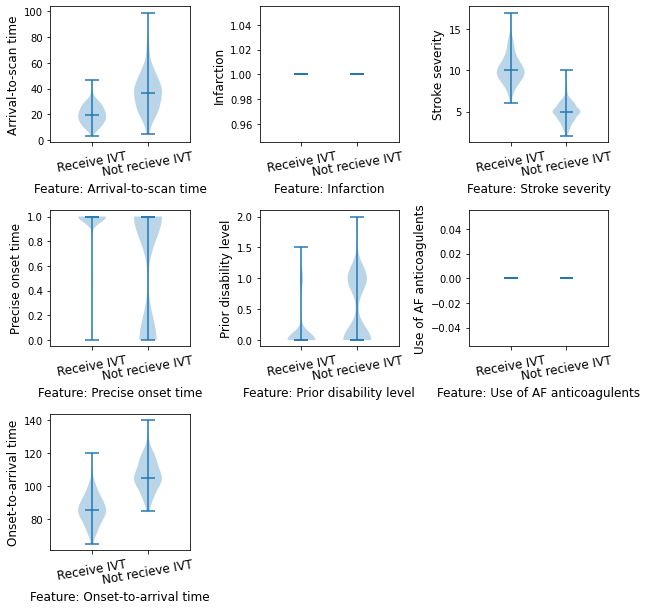

In [22]:
# Define columns to show violin plot for
columns = ["Arrival-to-scan time", "Infarction", "Stroke severity",
           "Precise onset time", "Prior disability level",
           "Use of AF anticoagulents", "Onset-to-arrival time"]

print (f"Distributions of the hospitals median value for each feature "
       f"(for thrombolysed and not thrombolysed patients)")
print()
#    print("Red line shows the feature value for the patient most suitable to "
#          "thrombolysis, according to model output [probability], but in real "
#          "world this patient didn't receive thrombolysis")
#    print()

fig = plt.figure(figsize=(10,10))

n_categories = 2 # thrombolyse, and not

ncols = 3
nrows = int((len(columns)/ncols)+1)
counter = 0
for col in columns:
    counter += 1
    # create violin plot
    ax = fig.add_subplot(nrows, ncols, counter)
    ax.violinplot([median_hospital_population_ivt [col],
                   median_hospital_population_not_ivt[col]],
                  showmedians=True)#, widths=width, )

    # customise the axes
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, n_categories+1))
    ax.set_xticklabels(["Receive IVT", "Not recieve IVT"], 
                        rotation=10, fontsize=12)
    ax.set_xlim(0.25, n_categories + 0.75)

    ax.set_ylabel(f'{col}', fontsize=12)
    ax.set_xlabel(f'Feature: {col}', fontsize=12)

#        # Add line at position for most thrombolysable patient (in terms of
#        #   model probability)
#        patient_index = index_top_IVT_patient_cohort[stroke_team]
#        feature_value = data[col].iloc[patient_index]
#        ax.plot([0, n_categories + 1], [feature_value,feature_value],c='red')

    plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.show()